In [86]:
# OCR - Tesseract

from PIL import Image
import pytesseract
import cv2
import re
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt 

In [87]:
# https://blog.naver.com/PostView.nhn?blogId=tommybee&logNo=221307497468&parentCategoryNo=&categoryNo=54&viewDate=&isShowPopularPosts=true&from=search
# Define config parameters.
# '-l eng'  for using the English language
# '--oem 1' for using LSTM OCR Engine
# config = ('-l kor+eng --oem 1 --psm 3')
# config = ('-l kor --oem 2 --psm 3 ') # ERROR, oem : lagacy + lstm, no support kor
# config = ('-l kor --oem 1 --psm 1') # oem3 와 비슷

# kor > kor+eng, 영어를 함께 인식하면 오류율이 높아진다
# psm 정확도  6 >>> 12,11 > 3
config = ('-l kor --oem 1 --psm 6') 

In [88]:
def all_file_ocr_tesseract(image_folder):
    try:
        all_file = get_all_file(image_folder)
        result = []
        
        for image_file in all_file:
            img = cv2.imread(image_file)
            img = img_preprocessing(img)
            text = pytesseract.image_to_string(img, config=config)
            text = text_processing(text)
            
            result.append(text)
        
        print(result)
        print(result[0])

    except Exception as ex:
        print('ERROR:', ex)

In [89]:
def ocr_tesseract(image_path):
    try:
        #Image Read
        img = cv2.imread(image_path)
        
        # Image Preprocessing
        img = img_preprocessing(img)
        
        # Process OCR
        text = pytesseract.image_to_string(img, config=config)
        
        # 텍스트 공백, 줄바꿈 필터링
        result = text_processing(text)
        
        # 결과 출력
        print(result)
        
        # 결과에서 특정 문장 parsing
        parse_data = text_parse(result)
        
        # 파일에 결과 작성
        write_result(result, parse_data, image_path)
        
    except Exception as ex:
        print('ERROR:', ex)


In [105]:
# 결과 작성
def write_result(result, parse_data, image_path):
    #Get Current DateTime
    now = datetime.datetime.now()
    mode = 'w'
    
    # 결과 파일이 있으면 a mode, 없으면 w mode
    if os.path.isfile('res.txt'):
        mode = 'a'
        
    with open("res.txt", mode) as f:
        f.write(str(now) + '\n')
        f.write(image_path + '\n')
        f.write(str(result) + '\n')
        f.write('==================' * 4 + '\n')
        f.write(str(parse_data) + '\n')
        f.write('==================' * 7 + '\n')

In [91]:
# 해당 폴더에 있는 모든 파일들의 절대 경로+이름을 리턴한다        
def get_all_file(image_folder):
    path_files = os.getcwd() 
    file_name = next(os.walk('.'+image_folder))[2]
    all_file = [path_files + image_folder + '/' + file for file in file_name]
    
    return all_file

In [92]:
# 중복된 공백과 줄바꿈을 없앤다        
def text_processing(text):       
#     text = " ".join(text.split()) # 리스트를 문자열로 변환, 줄바꿈까지 다 없애버린다, 한줄씩의 줄바꿈은 필요
    text = re.sub(' +', ' ', text) # 중복 공백 제거
    text = text.replace('\n\n', '\n') # 중복 줄바꿈 제거
    text = text.split('\n') # \n 단위로 리스트로 변경
    
    return text

In [103]:
# 결과 텍스트에서 특정 문자가 있는 문장을 파싱한다
def text_parse(texts):
    #알고리즘을 개선하고 싶다.. 뭔가 없을까
    comp_list = ['거래금액', '총금액', '가맹점전화']
    result = []
    for text in texts:
        for comp in comp_list:
            if comp in text:
                result.append(text)
                print(text)
    return result
                

In [94]:
def show_img(image, alt='img'):
    # Set image name and path
    np_array = np.array(1)    
    path = os.getcwd() + '/images/Tesseract_' + alt + '.png'
    
    # cv이미지는 PIL이미지로 변경
    if type(image) == type(np_array):
        # Gray이미지는 그대로, BGR이미지는 RGB이미지로 변경
        if(len(image.shape)<3):
            print('gray')
        elif len(image.shape)==3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert cv image to PIL image
        image = Image.fromarray(image)

    # Image Save and Open
    image.save(path, dpi=(300, 300))
    image = Image.open(path)
    
    # Print Image Info
    print(alt, ' size : ', image.size)
    print(alt, ' dpi : ', image.info['dpi'])
    print('-' * 30)
    
    # Show Image
    plt.figure()
    plt.title(alt)
    plt.imshow(image)
    
    return path

In [95]:
#1. 아래의 전처리는 정확도를 떨어뜨린다, 가격이 잘 뽑히지 않음     
def img_preprocessing(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    #그레이 스케일 변환
#     gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]  #배경에서 전경 텍스트를 분할하기 위해 임계값을 사용
    
    show_img(gray, 'Preprocessing')
    return gray

gray
Preprocessing  size :  (410, 980)
Preprocessing  dpi :  (300, 300)
------------------------------
['시기 이이 기마제 ! 플림회 000다 노스', '16 카드슬은 !회원용|', '삼모:제추선불 블루비 티:김', '사업지번호: 350 00050 박은 기리', '110:104633-97248 전00:292-4363', '세주특별사시노 제주시 농문로4길 14 |밀도일', '동)', '카드번호19400-944-904-4155 일시불', '가맹점번호: 78443762 사동미제 전표', '거라밀시: 19/0/11 10:8:1000', '거래금액: 10. 910원', '세금: 1 . 090원', '총금액: 12. 000원', '승인변호: 30000774', '매입사:국민카드 발급사:배 세크카드', '가맹점전화: 010 4339-4624', '16 카드승인 [가맹점용]', '상오:세주선물 블루버미 대표사:김성희', '사업자번호: 369-09-00250', '110:100634 072 - 전파0:29200', '지-태뷔사시도 세주시 농문로4길 14 [일도일', '키2번오:9400 0 시동 일시불', '가맹점번호: 70443762 사농미제 전표', '거라밀사: 19/10/1 10960000', '라99: 00000 10.90빌', '갈마 부일', '총멈액: 12. 0008', '슬오번조: 306 74', '아노 든 { 30000248 과']
거래금액: 10. 910원
총금액: 12. 000원


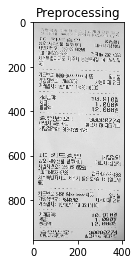

In [106]:
if __name__ == '__main__':
    image_folder = '/images/video_receipt'
    image_path = 'images/Preprocessing_rotated_mat.png'
    
    ocr_tesseract(image_path)